#Basic preprocessed


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define a PositionalEncoding layer for the Transformer
# Define a PositionalEncoding layer for the Transformer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_seq_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_seq_length, d_model)

    def call(self, inputs):
        return inputs + self.pos_encoding

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.math.pow(10000, (2 * (i // 2) / tf.cast(d_model, dtype=tf.float32)))
        return pos * angle_rates

    def positional_encoding(self, max_seq_length, d_model):
        angle_rads = self.get_angles(tf.range(max_seq_length)[:, tf.newaxis], tf.range(d_model)[tf.newaxis, :], d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])  # Apply sin to even indices
        cosines = tf.math.cos(angle_rads[:, 1::2])  # Apply cos to odd indices

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

# Define the Transformer encoder model with dropout and normalization
def transformer_encoder(max_seq_length, vocab_size, num_classes, d_model=128, num_heads=8, num_layers=4, dff=256, rate=0.1):
    inputs = keras.Input(shape=(max_seq_length,))

    # Add an embedding layer
    x = layers.Embedding(vocab_size, d_model)(inputs)
    x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    #x = PositionalEncoding(trainable=False)(x)

    # Transformer Encoder layers
    for _ in range(num_layers):
        # Multi-Head Attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
        attn_output = layers.Dropout(rate)(attn_output)
        out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feedforward
        ffn_output = layers.Dense(dff, activation="relu")(out1)
        ffn_output = layers.Dense(d_model)(ffn_output)
        ffn_output = layers.Dropout(rate)(ffn_output)
        out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

        x = out2

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Example usage:
max_seq_length = 128  # Maximum sequence length
vocab_size = 10000  # Define your vocabulary size
num_classes = 2  # Number of classes

model = transformer_encoder(max_seq_length, vocab_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 128, 128)             1280000   ['input_1[0][0]']             
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 128, 128)             0         ['embedding[0][0]']           
 da)                                                                                              
                                                                                                  
 multi_head_attention (Mult  (None, 128, 128)             66048     ['tf.math.multiply[0][0]',

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your dataset from a CSV file
# Load your dataset from an Excel file
df = pd.read_excel("train_data_basic_preprocessed.xlsx")

# Extract text and labels
texts = df["tokenized_comments"].tolist()
labels = df["Label"].tolist()

# Define your vocabulary size
vocab_size = 10000

# Tokenize the text data and pad it
max_seq_length = 128  # Maximum sequence length
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_seq_length, padding="post", truncating="post")

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 64
epochs = 5
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)


Epoch 1/5
40/40 [==============================] - 88s 2s/step - loss: 0.9508 - accuracy: 0.5047 - val_loss: 0.6997 - val_accuracy: 0.4609
Epoch 2/5
40/40 [==============================] - 76s 2s/step - loss: 0.6965 - accuracy: 0.5234 - val_loss: 0.6806 - val_accuracy: 0.5391
Epoch 3/5
40/40 [==============================] - 75s 2s/step - loss: 0.4695 - accuracy: 0.7820 - val_loss: 0.6355 - val_accuracy: 0.7281
Epoch 4/5
40/40 [==============================] - 75s 2s/step - loss: 0.1671 - accuracy: 0.9395 - val_loss: 0.6982 - val_accuracy: 0.7281
Epoch 5/5
40/40 [==============================] - 80s 2s/step - loss: 0.0668 - accuracy: 0.9793 - val_loss: 0.9688 - val_accuracy: 0.7219


In [ ]:
# Load testing data from test.xlsx
test_df = pd.read_excel("test_data_basic_preprocessed.xlsx")

# Extract text and labels
test_texts = test_df["tokenized_comments"].tolist()
test_labels = test_df["Label"].tolist()

# Tokenize and pad the testing text data
sequences = tokenizer.texts_to_sequences(test_texts)  # Use the tokenizer from training data
X_test = pad_sequences(sequences, maxlen=max_seq_length, padding="post", truncating="post")

# Encode the testing labels
y_test = label_encoder.transform(test_labels)

# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")


25/25 [==============================] - 10s 337ms/step - loss: 0.9494 - accuracy: 0.7175
Testing Accuracy: 71.75%


20/20 [==============================] - 9s 419ms/step


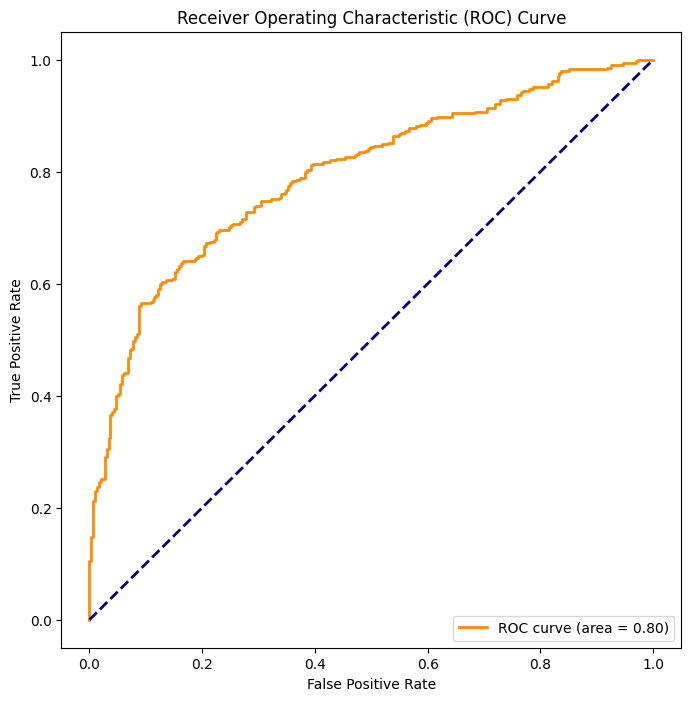

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_prob = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

25/25 [==============================] - 9s 339ms/step


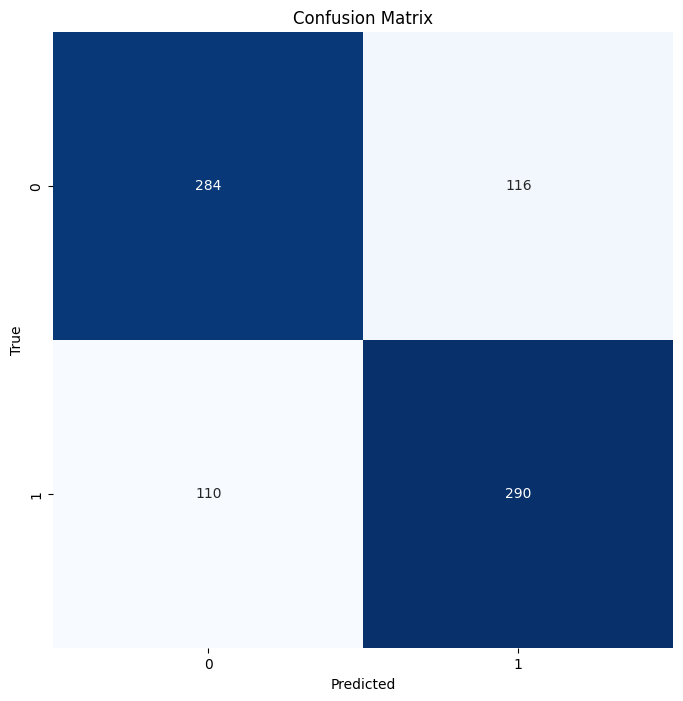

In [ ]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:",recall)
print("F1-Score:", f1)

Accuracy: 0.7175
Precision: 0.7208121827411168
Recall: 0.71
F1-Score: 0.7153652392947102
